In [1]:
cd /content/drive/My Drive/Colab Notebooks/Projects/Monkey_species_classification

/content/drive/My Drive/Colab Notebooks/Projects/Monkey_species_classification


In [3]:
ls

10-monkey-species/
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Monkey_Model_10.h5
Monkey_species_classification.ipynb


In [0]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg

In [5]:
title_stamp = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projects/Monkey_species_classification/10-monkey-species/monkey_labels.csv')
title_stamp

Label     Latin Name             ...  Train Images    Validation Images
0  n0         alouatta_palliata\t   ...            131                  26
1  n1        erythrocebus_patas\t   ...            139                  28
2  n2        cacajao_calvus\t       ...            137                  27
3  n3        macaca_fuscata\t       ...            152                  30
4  n4       cebuella_pygmea\t       ...            131                  26
5  n5       cebus_capucinus\t       ...            141                  28
6  n6       mico_argentatus\t       ...            132                  26
7  n7      saimiri_sciureus\t       ...            142                  28
8  n8       aotus_nigriceps\t       ...            133                  27
9  n9       trachypithecus_johnii   ...            132                  26

[10 rows x 5 columns]

In [0]:
training_numbers = 1098
testing_numbers = 272

batch_size = 32

In [7]:
training_dir = '/content/drive/My Drive/Colab Notebooks/Projects/Monkey_species_classification/10-monkey-species/training/training/'
test_dir = "/content/drive/My Drive/Colab Notebooks/Projects/Monkey_species_classification/10-monkey-species/validation/validation/"

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                   )

test_datagen = ImageDataGenerator(rescale = 1./255.)


train_generator = train_datagen.flow_from_directory(training_dir,
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (150,150))
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size = batch_size,
                                                  shuffle = False,
                                                  class_mode = 'categorical',
                                                  target_size = (150,150))


Using TensorFlow backend.


Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [0]:
index = 0

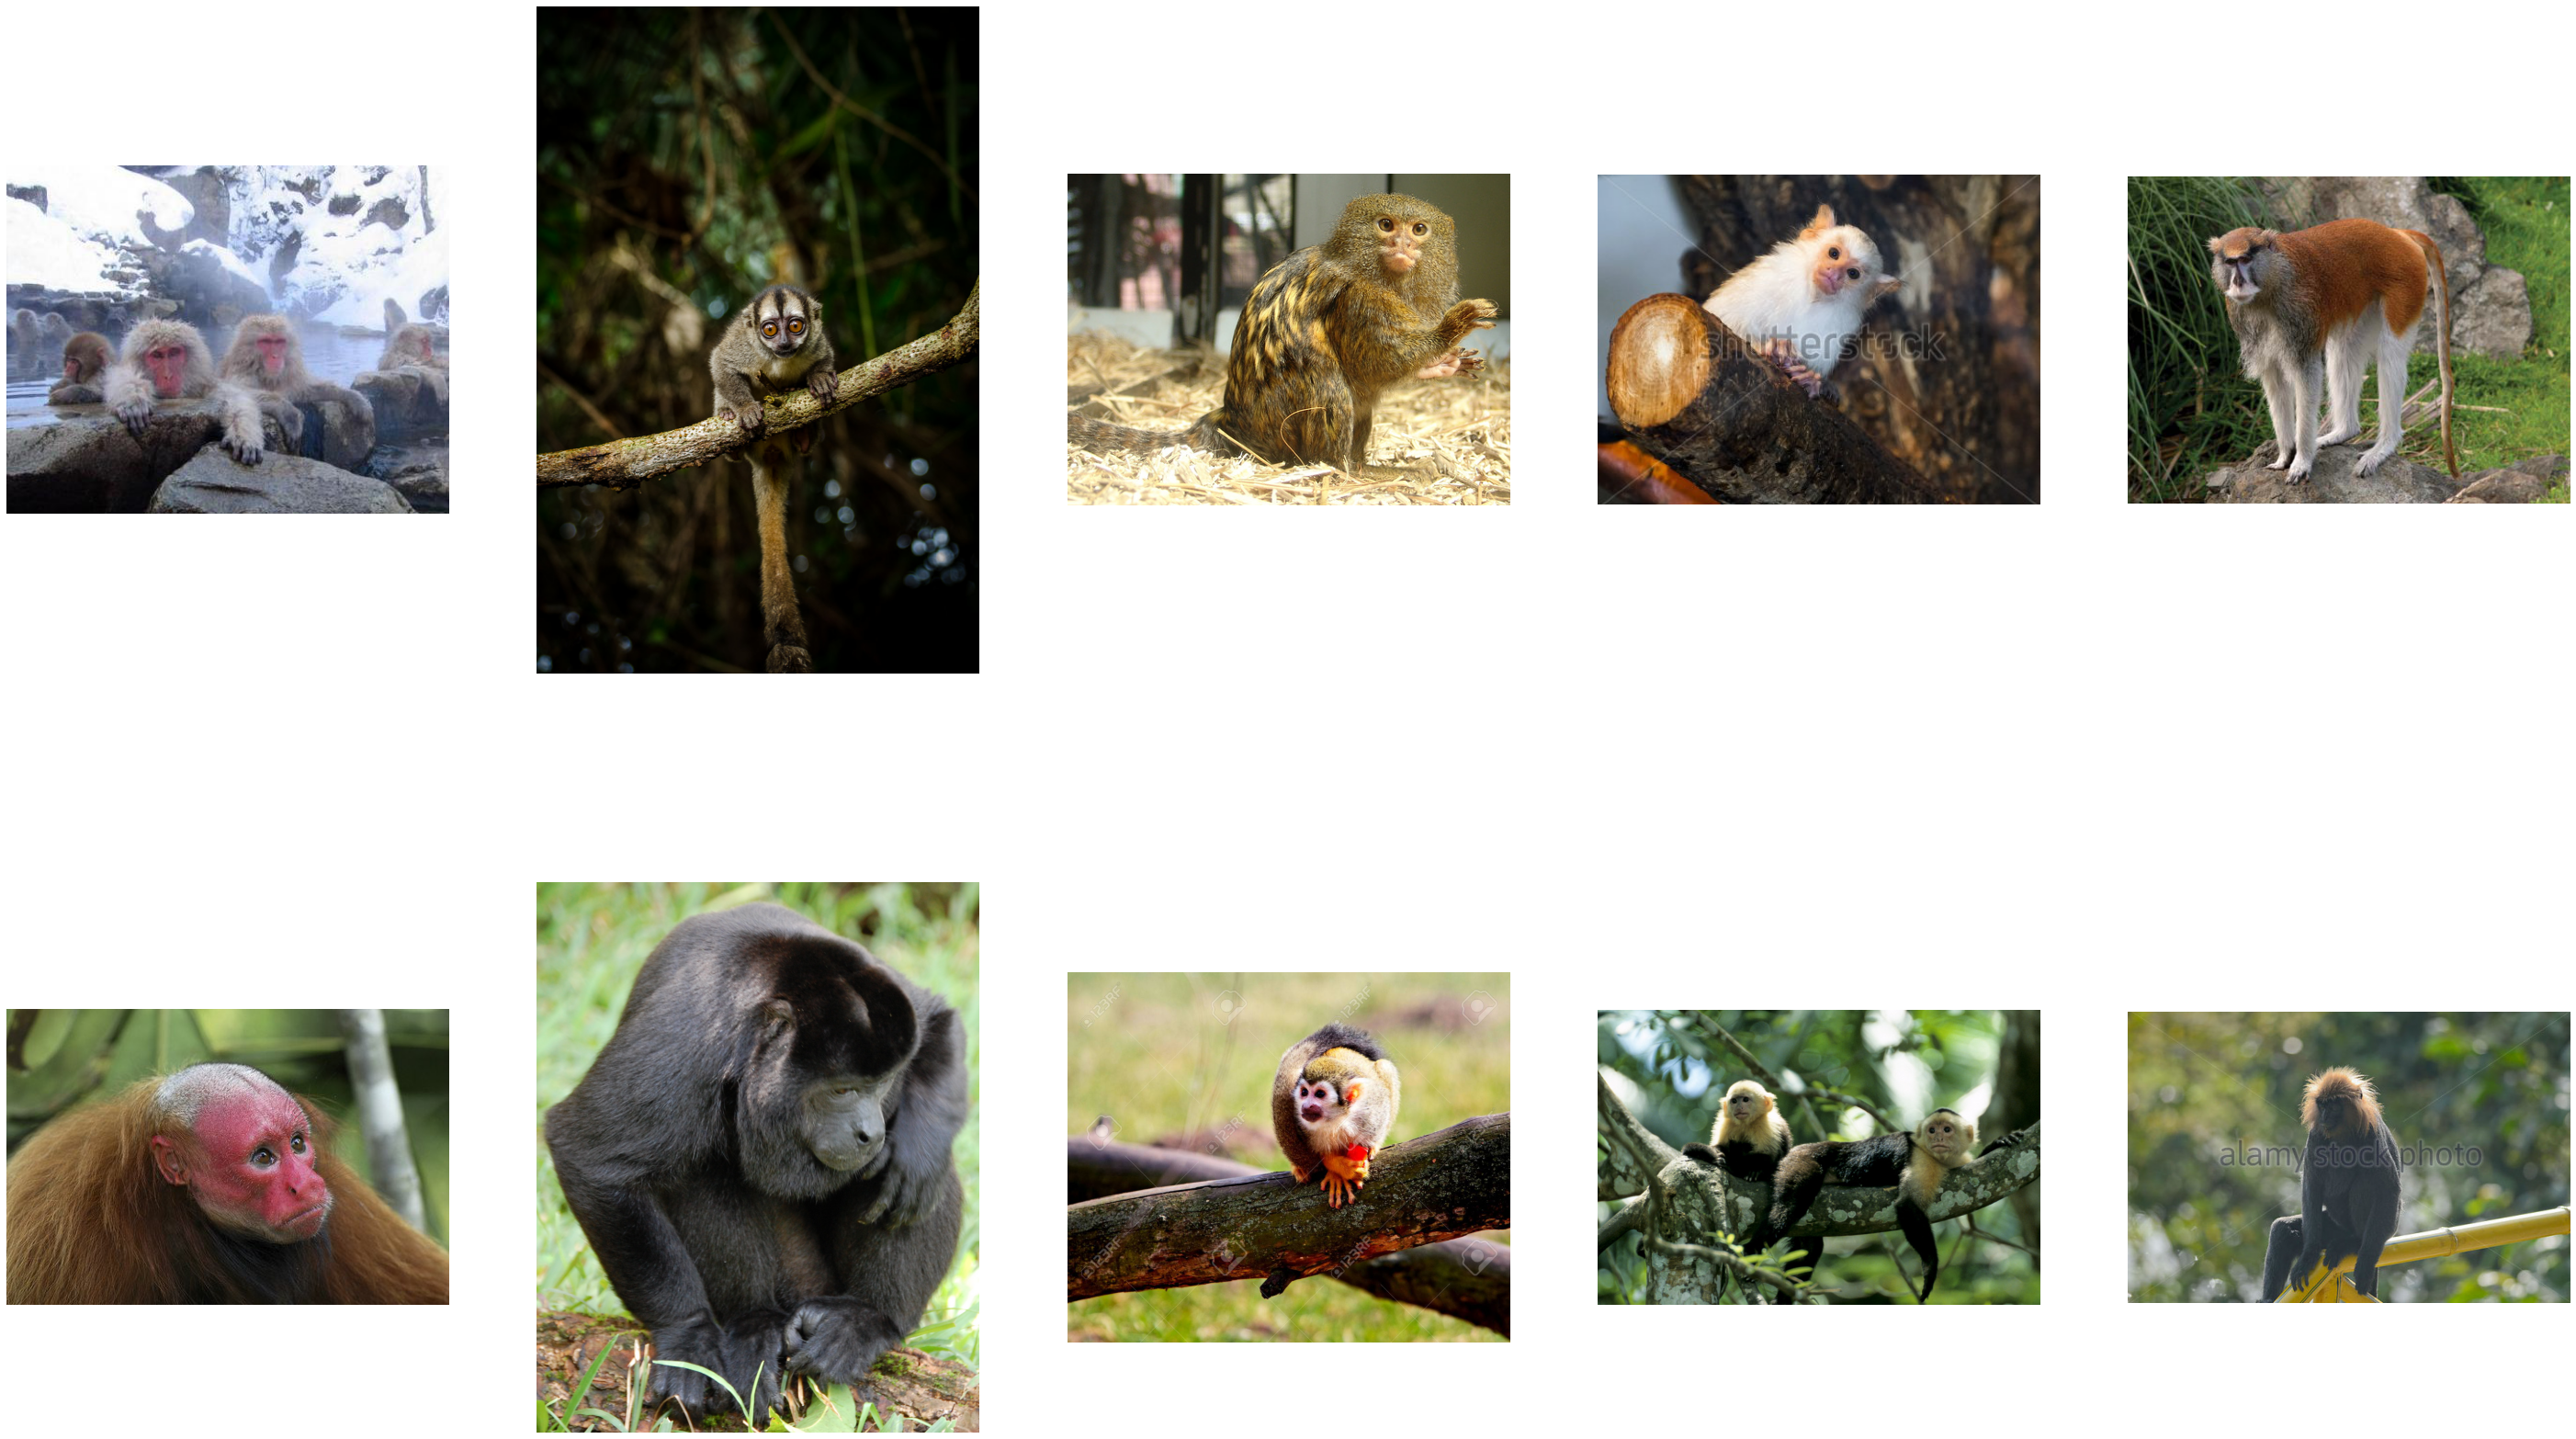

In [9]:
import os 
fig = plt.gcf()
fig.set_size_inches(50,30)
index += 1
l = os.listdir(training_dir)
pic = []
for i in l:
    class_dir = os.path.join(training_dir,i)
    image = os.listdir(class_dir)[index]
    pic.append(os.path.join(class_dir,image))
    

for j,k in enumerate(pic):
    sp = plt.subplot(2, 5, j + 1)
    sp.axis('off')
    img = mpimg.imread(k)
    plt.imshow(img)


plt.show()

# **Transfer Learning Using Inception_V3 pretrained model**

In [33]:
#local_weights_file = '/content/drive/My Drive/Colab Notebooks/Projects/Monkey_species_classification/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from tensorflow.python.keras.applications import ResNet50
from tensorflow.keras import layers

pre_trained_model = InceptionV3(input_shape = (150,150, 3),
                                include_top = False,
                                weights = 'imagenet')
#pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

#pre_trained_model.summary()

for (i,layer) in enumerate(pre_trained_model.layers):
    print(str(i),layer.__class__.__name__,layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 MaxPooling2D False
11 Conv2D False
12 BatchNormalization False
13 Activation False
14 Conv2D False
15 BatchNormalization False
16 Activation False
17 MaxPooling2D False
18 Conv2D False
19 BatchNormalization False
20 Activation False
21 Conv2D False
22 Conv2D False
23 BatchNormalization False
24 BatchNormalization False
25 Activation False
26 Activation False
27 AveragePooling2D False
28 Conv2D False
29 Conv2D False
30 Conv2D False
31 Conv2D False
32 BatchNormalization False
33 BatchNormalization False
34 BatchNormalization False
35 BatchNormalization False
36 Activation False
37 Activation False
38 Activation False
39 Activation False
40 Concatenate False
41 Conv2D False
42 BatchNormalization False
43 Activation False
44 Conv2D False
45 Conv2D False
46 BatchNormalization False
47 Batc

# Defining CallBacks

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('Monkey_Model_Classifier.h5',
                             monitor = 'val_loss',
                             mode = min,
                             save_best_only = True,
                             verbose = 1)
earlystop = EarlyStopping( monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',
                                            patience = 5,
                                            verbose = 1,
                                            factor = 0.2,
                                            min_lr = 0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

In [0]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [36]:
x = layers.GlobalAveragePooling2D()(last_output)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(10,activation='softmax')(x)

model_TL = Model(pre_trained_model.input,x)
model_TL.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_TL.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [37]:
epoch = 35

history2 = model_TL.fit_generator(train_generator,epochs= epoch, steps_per_epoch= (training_numbers//batch_size)+1,
                                  validation_data=test_generator,validation_steps= (testing_numbers//batch_size)+1,
                                  callbacks = callbacks)

Epoch 1/35
35/35 [==============================] - ETA: 0s - loss: 1.4875 - accuracy: 0.5128
Epoch 00001: val_loss improved from inf to 0.69406, saving model to Monkey_Model_Classifier.h5
35/35 [==============================] - 38s 1s/step - loss: 1.4875 - accuracy: 0.5128 - val_loss: 0.6941 - val_accuracy: 0.7684 - lr: 0.0010
Epoch 2/35
35/35 [==============================] - ETA: 0s - loss: 0.5542 - accuracy: 0.8270
Epoch 00002: val_loss improved from 0.69406 to 0.28780, saving model to Monkey_Model_Classifier.h5
35/35 [==============================] - 40s 1s/step - loss: 0.5542 - accuracy: 0.8270 - val_loss: 0.2878 - val_accuracy: 0.9191 - lr: 0.0010
Epoch 3/35
35/35 [==============================] - ETA: 0s - loss: 0.4013 - accuracy: 0.8689
Epoch 00003: val_loss improved from 0.28780 to 0.20413, saving model to Monkey_Model_Classifier.h5
35/35 [==============================] - 40s 1s/step - loss: 0.4013 - accuracy: 0.8689 - val_loss: 0.2041 - val_accuracy: 0.9412 - lr: 0.0010

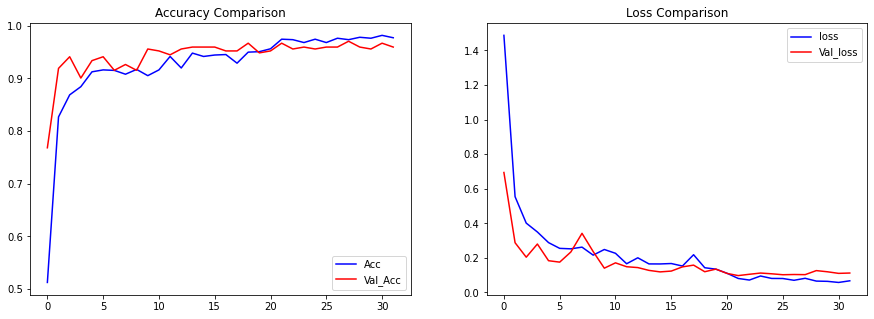

In [38]:
es_epoch = 32 #early stopping epoch
f1,ax1 = plt.subplots(1,2,figsize=(15,5))

ax1[0].plot(range(es_epoch),history2.history['accuracy'],'b', label = 'Acc')
ax1[0].plot(range(es_epoch),history2.history['val_accuracy'],'r',label = 'Val_Acc')
ax1[0].set_title('Accuracy Comparison')
ax1[0].legend(loc = "lower right")

ax1[1].plot(range(es_epoch),history2.history['loss'],'b',label = 'loss')
ax1[1].plot(range(es_epoch),history2.history['val_loss'],'r',label = 'Val_loss')
ax1[1].set_title('Loss Comparison')
ax1[1].legend(loc = "upper right")

plt.show()

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = model_TL.predict_generator(test_generator, testing_numbers//batch_size+1)

y_pred = np.argmax(y_pred, axis=1)
le = [0,1,2,3,4,5,6,7,8,9]

In [70]:
prediction = []
for i in range(0,272):
    prediction.append(le[y_pred[i]])
predictions = np.array(prediction)

print('Confusion Matrix\r')
print(confusion_matrix(test_generator.classes,predictions))
print('\rClassification Report\r')
print(classification_report(test_generator.classes,predictions))

Confusion Matrix
[[25  0  0  0  0  0  0  0  0  1]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 26  0  1  0  0  0  0  0]
 [ 0  0  0 28  0  0  0  1  0  1]
 [ 0  0  1  0 25  0  0  0  0  0]
 [ 1  0  0  0  0 26  1  0  0  0]
 [ 0  0  0  0  0  0 25  1  0  0]
 [ 0  0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0  0  0 27  0]
 [ 0  0  0  0  0  0  0  0  1 25]]
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       1.00      1.00      1.00        28
           2       0.96      0.96      0.96        27
           3       1.00      0.93      0.97        30
           4       0.96      0.96      0.96        26
           5       1.00      0.93      0.96        28
           6       0.96      0.96      0.96        26
           7       0.93      1.00      0.97        28
           8       0.96      1.00      0.98        27
           9       0.93      0.96      0.94        26

    accuracy                      

In [0]:
from tensorflow.keras import models
monkey_model = models.load_model('Monkey_Model_Classifier.h5')

# **Testing On Downloaded Images**

In [0]:
labels = list(title_stamp[' Common Name                   '])

In [73]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

p = '/content/drive/My Drive/Colab Notebooks/Projects/Monkey_species_classification/'
uploaded = files.upload()

for fn in uploaded.keys():
    path = p+fn
    img = image.load_img(path, target_size = (150,150))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = x.astype('float32')/255
    images = np.vstack([x])

    pred = np.argmax(monkey_model.predict(images)[0])
    print(str(fn)+" is a",labels[pred])


Saving howler.jpeg to howler.jpeg
Saving bald_ukari.jpeg to bald_ukari.jpeg
Saving bhnm.jpeg to bhnm.jpeg
Saving n3.jpeg to n3.jpeg
howler.jpeg is a  mantled_howler                
bald_ukari.jpeg is a  bald_uakari                   
bhnm.jpeg is a  black_headed_night_monkey     
n3.jpeg is a  japanese_macaque              
